# Reinforcement Learning for Stock Trading

Welcome to this notebook where we explore how to train a reinforcement learning (RL) agent to trade stocks using real historical data from **Apple Inc. (AAPL)**. We will explore the application of **Q-Learning**, a classical reinforcement learning technique. Our goal is to train an RL agent to make buy, sell, or hold decisions based on technical indicators derived from historical market data.

Our workflow will include:
- Collecting and preprocessing market data
- Engineering meaningful features using technical indicators
- Designing a custom trading environment
- Training and evaluating RL agents

Let's begin by installing and importing the necessary libraries.

In [2]:
!pip3 install yfinance
!pip3 install gymnasium
!pip3 install matplotlib

In [1]:
import yfinance as yf
from technical_indicators import technical_indicators
from q_learning import QLearningAgent
from environment import TradingEnv
import numpy as np
import matplotlib.pyplot as plt

seed=42

# Collecting and Preprocessing market data

In this section, we will download historical market data for **Apple Inc. (AAPL)** and preprocess it for use in our Q-Learning environment. This will include generating technical indicators, handling missing values, and preparing the data for training our agent.

In [2]:
df = yf.download("AAPL", start="2015-01-01", end="2024-01-01", multi_level_index=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Let's have a first look at the downloaded data.

In [3]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.320435,24.789804,23.879983,24.778681,212818400
2015-01-05,23.635281,24.169160,23.448424,24.089078,257142000
2015-01-06,23.637510,23.897776,23.274916,23.699796,263188400
2015-01-07,23.968962,24.069063,23.735389,23.846614,160423600
2015-01-08,24.889896,24.947734,24.180281,24.298181,237458000


Next, we calculate the technical indicators that will serve as the basis for our Q-Learning agent's decision-making process. These indicators include:
- Relative Strength Index (RSI)
- Moving Average Convergence Divergence (MACD)
- Simple Moving Average (SMA) Crossover
- Bollinger Bands
- Stochastic Oscillator (SO)

These indicators will help the agent assess market conditions and make informed trading decisions.

In [4]:
technical_indicators(df=df)
df.head()

,Close,High,Low,Open,Volume,SMA,EMA,SMA_short,SMA_long,Crossover_signal,RSI,RSI_signal,MACD_signal,Upper_Band,Lower_Band,BB_signal,Stochastic_Osc,SO_signal
Date,,,,,,,,,,,,,,,,,,
2015-01-02,24.320435,24.789804,23.879983,24.778681,212818400,NaN,24.320435,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0
2015-01-05,23.635281,24.169160,23.448424,24.089078,257142000,NaN,24.229081,NaN,NaN,0,NaN,0,-1,NaN,NaN,0,NaN,0
2015-01-06,23.637510,23.897776,23.274916,23.699796,263188400,NaN,24.150205,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0
2015-01-07,23.968962,24.069063,23.735389,23.846614,160423600,NaN,24.126039,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0
2015-01-08,24.889896,24.947734,24.180281,24.298181,237458000,NaN,24.227887,24.090417,NaN,0,NaN,0,1,NaN,NaN,0,NaN,0


Since some of these indicators, like the moving averages, generate NaN values in the initial rows, we drop these rows to ensure the data is clean and ready for use by our agent.

In [5]:
df.dropna(axis=0, how='any', inplace=True)
df.head()

,Close,High,Low,Open,Volume,SMA,EMA,SMA_short,SMA_long,Crossover_signal,RSI,RSI_signal,MACD_signal,Upper_Band,Lower_Band,BB_signal,Stochastic_Osc,SO_signal
Date,,,,,,,,,,,,,,,,,,
2015-01-30,26.062212,26.693968,25.993251,26.338049,334982000,24.986669,25.041501,25.519883,24.612174,0,58.434310,0,0,26.210719,23.013630,0,86.521911,-1
2015-02-02,26.389217,26.509340,25.821971,26.260198,250956400,25.267846,25.221197,25.765912,24.715614,0,66.039666,0,0,26.492462,22.938765,0,97.908567,-1
2015-02-03,26.393661,26.491538,26.162314,26.360294,207662800,25.488739,25.377525,26.189010,24.853533,0,64.899206,0,0,26.703992,23.003073,0,98.063316,-1
2015-02-04,26.596090,26.807419,26.318028,26.360294,280598800,25.711411,25.540001,26.378092,25.001462,0,66.956130,0,0,26.914579,23.088344,0,100.000000,-1
2015-02-05,26.785919,26.850684,26.631823,26.803784,168984800,25.889668,25.706123,26.445420,25.142309,0,75.500213,1,0,27.147910,23.136709,0,100.000000,-1


As a final preprocessing step, we need to adjust the index of our dataset to match the requirements of our reinforcement learning agent. Specifically, we reset the index so that it starts from 0 and goes up to the length of the dataset. This ensures the agent can properly interact with the environment using a consistent and sequential index.

In [6]:
df['Date'] = df.index
df.reset_index(drop=True, inplace=True)
df.head()

,Close,High,Low,Open,Volume,SMA,EMA,SMA_short,SMA_long,Crossover_signal,RSI,RSI_signal,MACD_signal,Upper_Band,Lower_Band,BB_signal,Stochastic_Osc,SO_signal,Date
0,26.062212,26.693968,25.993251,26.338049,334982000,24.986669,25.041501,25.519883,24.612174,0,58.434310,0,0,26.210719,23.013630,0,86.521911,-1,2015-01-30
1,26.389217,26.509340,25.821971,26.260198,250956400,25.267846,25.221197,25.765912,24.715614,0,66.039666,0,0,26.492462,22.938765,0,97.908567,-1,2015-02-02
2,26.393661,26.491538,26.162314,26.360294,207662800,25.488739,25.377525,26.189010,24.853533,0,64.899206,0,0,26.703992,23.003073,0,98.063316,-1,2015-02-03
3,26.596090,26.807419,26.318028,26.360294,280598800,25.711411,25.540001,26.378092,25.001462,0,66.956130,0,0,26.914579,23.088344,0,100.000000,-1,2015-02-04
4,26.785919,26.850684,26.631823,26.803784,168984800,25.889668,25.706123,26.445420,25.142309,0,75.500213,1,0,27.147910,23.136709,0,100.000000,-1,2015-02-05


Now that we have preprocessed our market data, including calculating technical indicators and resetting the index, the data is ready to be fed into our Q-Learning agent. We can proceed with training the agent using this cleaned and structured data.

# Training the Q-Learning Agent

To evaluate the performance of our Q-Learning agent, we first need to split the data into a training and testing set. Since we are working with time-series data, it’s important to respect the temporal order of the data to simulate real-world trading conditions, where the agent cannot see future data during training.

We will split the data into 80% for training and 20% for testing.

In [7]:
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]
test_data.reset_index(drop=True, inplace=True)
test_data.head()

,Close,High,Low,Open,Volume,SMA,EMA,SMA_short,SMA_long,Crossover_signal,RSI,RSI_signal,MACD_signal,Upper_Band,Lower_Band,BB_signal,Stochastic_Osc,SO_signal,Date
0,161.365311,161.857338,157.212598,157.950639,123511700,155.760126,157.895645,155.460971,158.747726,0,48.749966,0,1,167.440835,150.054617,0,83.814208,-1,2022-03-18
1,162.742996,163.697531,160.410776,160.902803,95811400,156.358432,158.541959,158.365903,158.653255,0,52.417927,0,0,167.115089,150.191422,0,92.597190,-1,2022-03-21
2,166.128113,166.718537,162.280456,162.870879,81532000,157.478287,159.553446,161.068115,158.874667,1,52.502164,0,0,167.886047,149.863287,0,100.000000,-1,2022-03-22
3,167.495987,169.887233,164.976794,165.311384,98062700,158.192711,160.612451,163.158255,159.373582,0,54.305536,0,0,169.141748,149.605417,0,100.000000,-1,2022-03-23
4,171.294418,171.363294,167.495966,168.332404,90131400,159.722916,162.036714,165.805365,159.931048,0,61.590774,0,0,171.062102,148.799994,-1,100.000000,-1,2022-03-24


First, we set up our trading environment.

In [ ]:
env = TradingEnv(data=train_data, initial_cash=10000, max_num_shares=100, max_short_position=100, cost_per_trade=0)
env.action_space.seed(seed)

123

Next, we initialize our Q-Learning agent and train it on our train data.

In [9]:
agent = QLearningAgent(action_space=env.action_space, observation_space=env.observation_space)
agent.train(env=env, num_episodes=1000)

Training finished! Epsilon: 0.010


# Evaluating the Q-Learning Agent on the Training Set

In this section, we evaluate the performance of our agent on the training set and compare it to the performance of a random strategy.

In [13]:
state, _ = env.reset(seed=seed)

Next, we evaluate our agent on the training set. To do this, we will set epsilon to zero, meaning that the agent will no longer explore randomly but will instead always choose the action that maximizes the Q-values (pure exploitation of the learned policy).


In [14]:
agent.epsilon = 0
done = False
portfolio_value = np.zeros(len(train_data)-1)
i = 0
while not done:
    action = agent.get_action(state)
    state, _, done, _ = env.step(action)
    portfolio_value[i] = env.portfolio_value
    print(f"Position:  {env.current_position}, Portfolio value: {env.portfolio_value}")
    i+=1

Position:  78, Portfolio value: 9978.48469851251
Position:  67, Portfolio value: 10002.57190320831
Position:  91, Portfolio value: 10003.670486598821
Position:  36, Portfolio value: 10009.122719068537
Position:  100, Portfolio value: 10014.813203779593
Position:  83, Portfolio value: 9996.395528153902
Position:  157, Portfolio value: 10030.375036942656
Position:  0, Portfolio value: 10046.151872047414
Position:  62, Portfolio value: 10075.367607691713
Position:  182, Portfolio value: 10107.96466659106
Position:  191, Portfolio value: 10132.76277903504
Position:  15, Portfolio value: 10151.389652004058
Position:  167, Portfolio value: 10191.3722808698
Position:  94, Portfolio value: 10181.790473415007
Position:  138, Portfolio value: 10212.480314518787
Position:  29, Portfolio value: 10247.806887235338
Position:  71, Portfolio value: 10235.208770394434
Position:  68, Portfolio value: 10183.470384100985
Position:  127, Portfolio value: 10229.701578318232
Position:  95, Portfolio value: 1

Text(0.5, 1.0, 'Q-Learning agent (Train Set)')

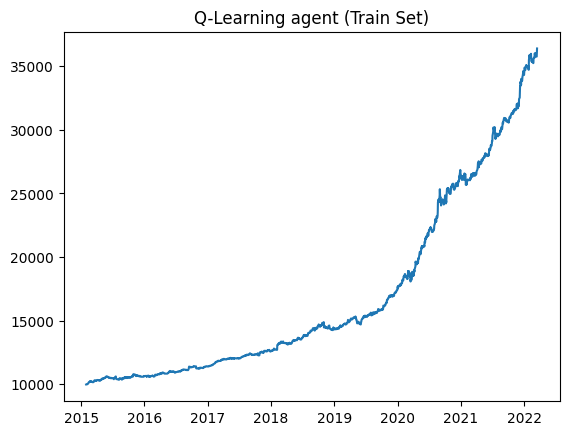

In [15]:
plt.plot(list(train_data["Date"][:-1]), portfolio_value)
plt.title('Q-Learning agent (Train Set)')

Next, we compare our strategy to a random strategy.

In [31]:
env.reset(seed=seed)
done = False
portfolio_value_random_strategy = []
i = 0
while not done:
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    portfolio_value_random_strategy.append(env.portfolio_value)
    print(f"Position:  {env.current_position}, Portfolio value: {env.portfolio_value}")
    i+=1

Position:  1, Portfolio value: 9999.724162801442
Position:  70, Portfolio value: 10008.953519582257
Position:  -33, Portfolio value: 10005.827724763827
Position:  -76, Portfolio value: 9989.008338002579
Position:  -71, Portfolio value: 9974.492019092486
Position:  -37, Portfolio value: 9982.230229077997
Position:  -16, Portfolio value: 9981.189410625951
Position:  -17, Portfolio value: 9972.557932095498
Position:  58, Portfolio value: 9997.041250446224
Position:  26, Portfolio value: 10014.648495921372
Position:  -6, Portfolio value: 10019.677784983676
Position:  94, Portfolio value: 10026.266062133764
Position:  -43, Portfolio value: 10011.600841764997
Position:  -21, Portfolio value: 10014.046551089426
Position:  47, Portfolio value: 10022.486155244276
Position:  -72, Portfolio value: 9980.027372359022
Position:  79, Portfolio value: 9967.407386241579
Position:  66, Portfolio value: 9915.816398114657
Position:  85, Portfolio value: 9946.758534417593
Position:  -97, Portfolio value: 9

Text(0.5, 1.0, 'Random Strategy (Train Set)')

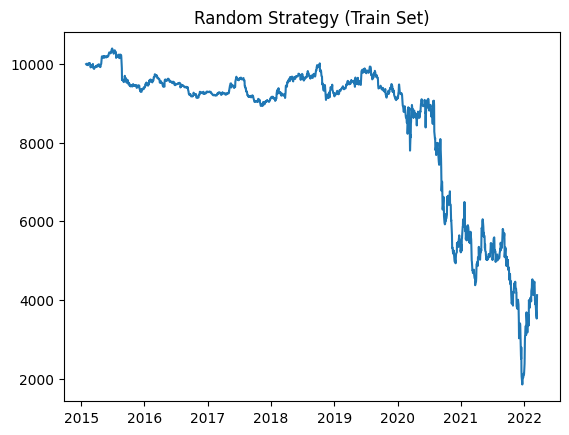

In [32]:
plt.plot(list(train_data["Date"][:-1]), portfolio_value_random_strategy)
plt.title('Random Strategy (Train Set)')

# Evaluating the Q-Learning Agent on the Test Set

In this section, we evaluate the Q-Learning Agent on the Test Set. To this end, we first initialiaze a new Trading environment, using the test data.

In [33]:
test_env = TradingEnv(data=test_data, initial_cash=10000, max_num_shares=100, max_short_position=100, cost_per_trade=0)
test_env.action_space.seed(123)

123

Next, we evaluate the performance of our Q-Learning Agent on the test set.

In [ ]:
state, _ = test_env.reset(seed=seed)
agent.epsilon = 0
done = False
portfolio_value_test = np.zeros(len(test_data)-1)
i = 0
while not done:
    action = agent.get_action(state)
    state, _, done, _ = test_env.step(action)
    portfolio_value_test[i] = test_env.portfolio_value
    print(f"Position:  {test_env.current_position}, Portfolio value: {test_env.portfolio_value}")
    i+=1

Position:  153, Portfolio value: 10522.444746049412
Position:  126, Portfolio value: 10683.545429563432
Position:  1, Portfolio value: 10702.915931268633
Position:  64, Portfolio value: 10841.913795957276
Position:  66, Portfolio value: 11090.937434174592
Position:  60, Portfolio value: 11128.193609525106
Position:  63, Portfolio value: 11190.279396877031
Position:  102, Portfolio value: 11485.702844402895
Position:  0, Portfolio value: 11444.54847986505
Position:  62, Portfolio value: 11247.481912873782
Position:  182, Portfolio value: 11262.242882630606
Position:  191, Portfolio value: 12036.18683782722
Position:  113, Portfolio value: 11588.188078879306
Position:  88, Portfolio value: 11242.060028913958
Position:  21, Portfolio value: 11204.29198937766
Position:  0, Portfolio value: 11196.85245600174
Position:  35, Portfolio value: 11094.904136019792
Position:  9, Portfolio value: 11169.89798487442
Position:  62, Portfolio value: 11351.150993802286
Position:  0, Portfolio value: 113

Text(0.5, 1.0, 'Q-Learning agent (Train Set)')

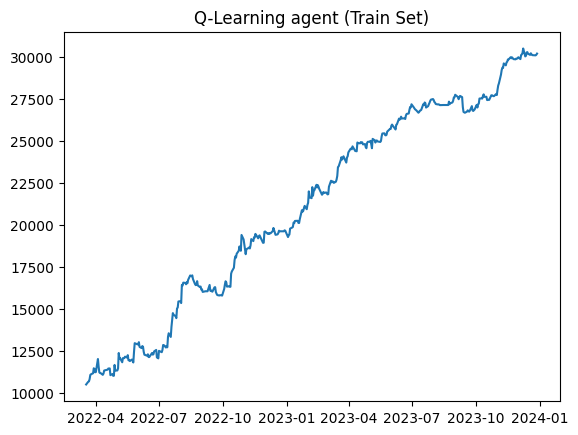

In [36]:
plt.plot(list(test_data["Date"][:-1]), portfolio_value_test)
plt.title('Q-Learning agent (Train Set)')

We compare the performance of our Q-Learning agent to the performance of simply holding the underlying asset over the same time period.

Text(0.5, 1.0, 'Apple (AAPL)')

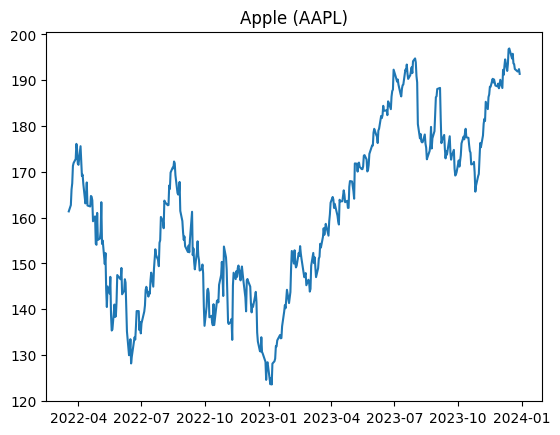

In [37]:
plt.plot(test_data['Date'],test_data['Close'])
plt.title("Apple (AAPL)")

Finally, we compare the performance of the Q-Learning agent to that of a random strategy over the same period.

In [50]:
test_env.reset(seed=seed)
done = False
portfolio_value_random_strategy_test = []
i = 0
while not done:
    action = env.action_space.sample()
    state, _, done, _ = test_env.step(action)
    portfolio_value_random_strategy_test.append(test_env.portfolio_value)
    print(f"Position:  {test_env.current_position}, Portfolio value: {test_env.portfolio_value}")
    i+=1

Position:  -63, Portfolio value: 9784.875692803183
Position:  50, Portfolio value: 9906.023287899603
Position:  -35, Portfolio value: 9798.414269586485
Position:  -89, Portfolio value: 9632.570111171022
Position:  -15, Portfolio value: 9513.698784049551
Position:  68, Portfolio value: 9572.71228618319
Position:  -72, Portfolio value: 9159.055840944908
Position:  -6, Portfolio value: 9068.424483024433
Position:  5, Portfolio value: 9067.007519974919
Position:  -34, Portfolio value: 9175.420651895334
Position:  -68, Portfolio value: 9176.089690912639
Position:  -66, Portfolio value: 8907.346279480636
Position:  40, Portfolio value: 8872.352399553907
Position:  -93, Portfolio value: 8814.57960147263
Position:  43, Portfolio value: 8917.363877839573
Position:  -41, Portfolio value: 8970.31581208492
Position:  -89, Portfolio value: 9285.233357826488
Position:  -28, Portfolio value: 9096.346501987564
Position:  70, Portfolio value: 9311.125117953055
Position:  -75, Portfolio value: 9719.6547

Text(0.5, 1.0, 'Random Strategy (Test Set)')

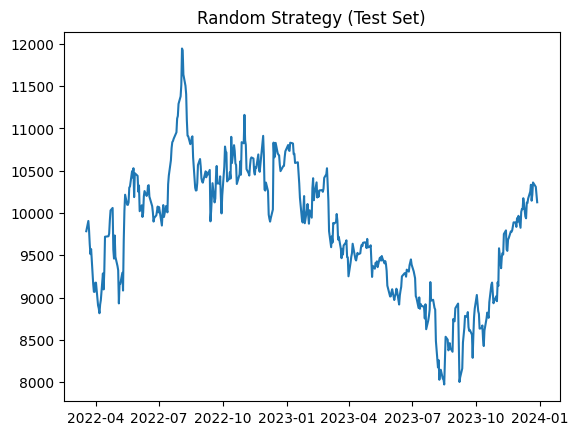

In [51]:
plt.plot(list(test_data["Date"][:-1]), portfolio_value_random_strategy_test)
plt.title('Random Strategy (Test Set)')